# Comparison of algorithms on mnist

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from random import sample
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline
from matplotlib import pyplot as plt

load mnist data

In [2]:
mnist = fetch_openml('mnist_784')

have a look into the data

In [3]:
mnist.data.shape

(70000, 784)

In [4]:
mnist.target.shape

(70000,)

In [5]:
print(type(mnist.data))
print(type(mnist.target)) # data and target are numpy arrays

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


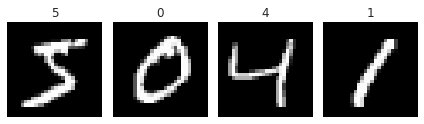

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=4)#, figsize=(10,40))
for i in range(len(axs)):
    axs[i].imshow(mnist.data[i,:].reshape([28,28]),cmap='gray')
    axs[i].set_title(str(mnist.target[i]))
    axs[i].axis('off')
fig.tight_layout()
plt.show()

separate data into train and test

In [7]:
X = mnist.data
y = mnist.target
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=23, stratify=y)

did stratification work properly?

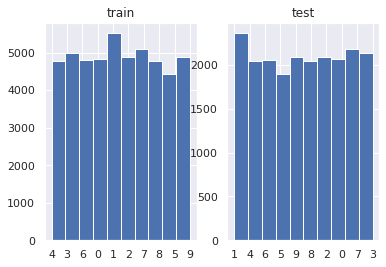

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].hist(y_train)
axs[0].set_title('train')
axs[1].hist(y_test)
axs[1].set_title('test')
plt.show()

looks similar enough

now let's train knn

## KNN

In [9]:
knn = KNeighborsClassifier(n_neighbors=10)

In [10]:
# for kNN, we need to scale features
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
#knn.fit(X_train_scaled, y_train)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [11]:
indicies = range(len(y_train))
indicies = sample(indicies, len(indicies)//10)

In [12]:
knn_pred_train = knn.predict(X_train[indicies])
accuracy_score(y_train[indicies], knn_pred_train)
# took 5 min for ~ 5k samples

0.9757142857142858

knn train accuracy is 0.976

In [15]:
indicies_test = range(len(y_test))
indicies_test = sample(indicies_test, len(indicies_test)//4)

In [17]:
knn_pred_test = knn.predict(X_test[indicies_test])
accuracy_score(y_test[indicies_test], knn_pred_test)

0.964952380952381

knn test accuracy is 0.965

Training in a grid would take too much time.

Lets try another algorithm instead.

## Time to plant a tree.

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
treeclf = DecisionTreeClassifier(max_depth=4)

In [23]:
treeclf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [24]:
tree_pred_train = treeclf.predict(X_train)
accuracy_score(y_train, tree_pred_train)

0.6334285714285715

In [25]:
tree_pred_test = treeclf.predict(X_test)
accuracy_score(y_test, tree_pred_test)

0.6297619047619047

Well that was SOME tree.
Now let's do a grid search for optimal parametres.

In [28]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params = {'max_depth': [3,5,7,10,15,20]}

tree = DecisionTreeClassifier(random_state=23)

tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=23,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
  

In [37]:
grid_results = pd.DataFrame(tree_grid.cv_results_)
grid_results = grid_results.loc[:,['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
grid_results = grid_results.sort_values('rank_test_score')
grid_results

,params,mean_test_score,std_test_score,rank_test_score
4,{'max_depth': 15},0.862469,0.002678,1
5,{'max_depth': 20},0.862020,0.002820,2
3,{'max_depth': 10},0.847408,0.003140,3
2,{'max_depth': 7},0.777551,0.004243,4
1,{'max_depth': 5},0.666388,0.008643,5
0,{'max_depth': 3},0.446306,0.008097,6


max depth 15 and 20 showed the same (within error) best result

In [39]:
tree_grid.best_score_

0.8624693877551021

In [40]:
accuracy_score(y_test, tree_grid.predict(X_test))

0.8665238095238095

and another one...

# perceptron

In [41]:
from sklearn.linear_model import SGDClassifier

In [44]:
clf = SGDClassifier(max_iter=1000, loss='perceptron', n_jobs=-1)

In [45]:
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='perceptron',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [46]:
clf_pred_train = clf.predict(X_train)
accuracy_score(y_train, clf_pred_train)

0.8874285714285715

In [47]:
clf_pred_test = clf.predict(X_test)
accuracy_score(y_test, clf_pred_test)

0.8711428571428571

In [48]:
clf2 = SGDClassifier(max_iter=1000, n_jobs=-1)
clf2.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [49]:
clf2_pred_train = clf2.predict(X_train)
print(accuracy_score(y_train, clf2_pred_train))
clf2_pred_test = clf2.predict(X_test)
print(accuracy_score(y_test, clf2_pred_test))

0.8717959183673469
0.8589523809523809


# Classify each pixel!

In [9]:
X_train.shape

(49000, 784)

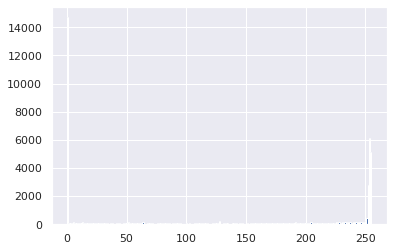

In [10]:
plt.hist(X_train[:,380], bins=250)
plt.show()

In [11]:
X_train[1,:][X_train[1,:]!=0]

array([  1.,   7.,  89., 155., 254., 254., 254., 254., 254., 212.,  85.,
         1.,  32., 253., 253., 253., 253., 253., 253., 253., 253., 253.,
       253.,  36.,  29., 246., 253., 240., 235., 143., 111., 111., 150.,
       250., 253., 145.,  67., 105.,  33.,  21., 215., 253.,  30.,  10.,
       211., 253., 242.,  27.,  44., 188., 253., 240.,  76.,   6.,  44.,
        44.,  35.,  33., 161., 253., 218.,  78.,  42., 183., 253., 253.,
       238., 174., 232., 253., 239.,  39.,   5., 172., 253., 253., 253.,
       253., 253., 253., 253., 195.,  39.,  19., 253., 253., 253., 253.,
       241., 191., 206., 253., 253., 232., 143.,   9.,  14., 225., 253.,
       243., 164.,  49.,  15.,  95., 238., 253., 253., 155.,   9.,  33.,
        55.,  47.,  43., 179., 253., 253.,  67.,  16., 179., 253., 234.,
        20.,  88., 253., 253.,  24.,  88., 253., 253., 130.,  88., 253.,
       253., 148.,  63., 106., 106.,  36.,  52., 138., 253., 253.,  97.,
       149., 253., 253., 242., 220., 112., 112., 11

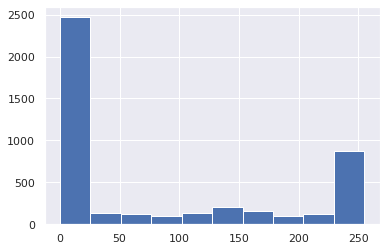

In [12]:
temp = X_train[:,156][y_train == '5']
plt.hist(temp)
plt.show()

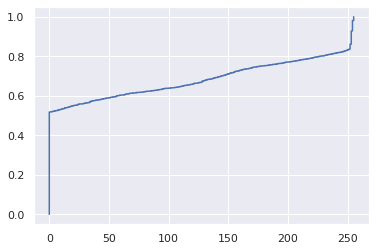

In [13]:
plt.plot(np.sort(temp),np.linspace(0, 1, len(temp)))

In [139]:
n_bins = 10

def categorize_intensity(intensity, n_bins):
    intensity_new = intensity / 255 * n_bins
    return intensity_new

X_train_category = np.array(categorize_intensity(X_train, n_bins), dtype=np.int_)
X_test_category = np.array(categorize_intensity(X_test, n_bins), dtype=np.int_)

In [140]:
# train

probabilities = {}
for i in range(X_train_category.shape[1]): # for each pixel
    for j in range(n_bins+1): # for each intensity category
        unique_counts = np.unique(y_train[X_train_category[:,i] == j], return_counts=True)
        a = {}
        for k in range(10): # digits
            a[k]=0
        for k in range(len(unique_counts[0])):
            a[int(unique_counts[0][k])] = unique_counts[1][k]/np.sum(unique_counts[1])
        probabilities[(i,j)] = a

In [141]:
# std for probs
# histogram
deviations = np.zeros([X_train_category.shape[1], n_bins+1])
for i in range(X_train_category.shape[1]): # for each pixel
    for j in range(n_bins+1): # for each intensity category
        deviations[i,j] = np.std(list(probabilities[(i,j)].values()))

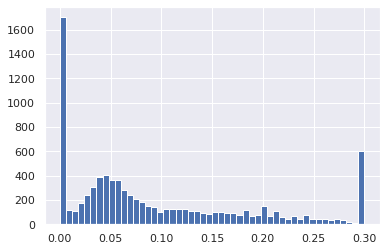

In [142]:
temp = deviations.flatten()
plt.hist(temp, bins=50)
plt.show()

In [143]:
threshold = 0.02
use = np.ones([X_train_category.shape[1], n_bins+1])
use[deviations < threshold] = 0

In [144]:
# test
amount = 2000

score = 0
for image_number in range(len(X_test_category[:amount,:])):
    image = X_test_category[image_number, :]
    a = {}
    for k in range(10):
        a[k] = 0
    for i in range(image.shape[0]):
        probs = probabilities[(i, image[i])]
        for k in range(10):
            a[k] += probs[k] * use[i, image[i]]
        
    #convert into probability
    #for x in a:
    #    a[x] = a[x]/image.shape[0]
    max_temp = 0
    for x in a:
        if a[max_temp] < a[x]:
            max_temp = x
    if int(y_test[image_number]) == max_temp:
        score += 1
accuracy = score/amount
print('Accuracy is', accuracy)

Accuracy is 0.6535
